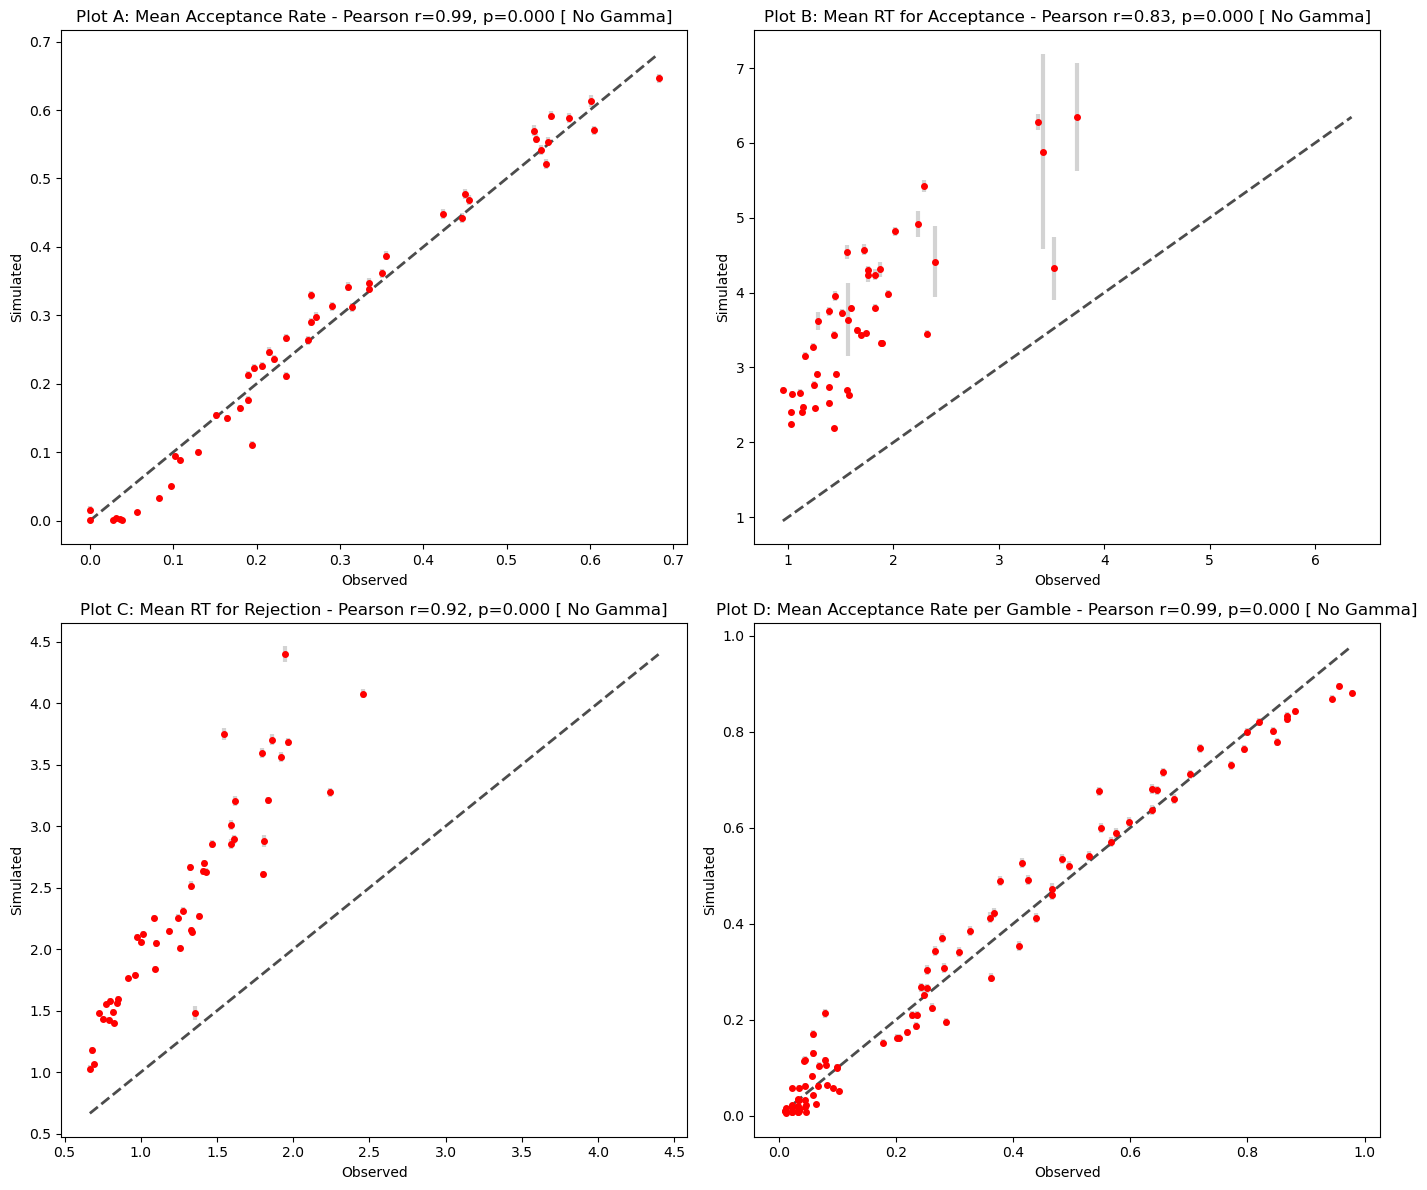

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, sem

def process_and_plot_data(observed_csv, simulated_csv, model_name):
    # Load data
    observed_df = pd.read_csv(observed_csv)
    simulated_df = pd.read_csv(simulated_csv)

    # Filter RTs greater than 10
    observed_df = observed_df[observed_df['rt'] <= 10]
    simulated_df = simulated_df[simulated_df['rt'] <= 10]

    # Calculate mean and 95% CI for observed and simulated data
    def mean_ci(data):
        return np.mean(data), sem(data) * 1.96  # 95% CI

    # Processing observed data
    observed_agg = observed_df.groupby('subj_idx').agg(
        mean_acceptance_rate=('response', 'mean'),
        mean_acceptance_rt=('rt', lambda x: np.mean(x[observed_df.loc[x.index, 'response'] == 1])),
        mean_rejection_rt=('rt', lambda x: np.mean(x[observed_df.loc[x.index, 'response'] == 0]))
    ).reset_index()

    # Processing simulated data
    simulated_agg = simulated_df.groupby('subj_idx').agg(
        mean_acceptance_rate=('response', lambda x: mean_ci(x)[0]),
        mean_acceptance_rt=('rt', lambda x: mean_ci(x[simulated_df.loc[x.index, 'response'] == 1])[0]),
        mean_rejection_rt=('rt', lambda x: mean_ci(x[simulated_df.loc[x.index, 'response'] == 0])[0]),
        acceptance_rate_ci=('response', lambda x: mean_ci(x)[1]),
        acceptance_rt_ci=('rt', lambda x: mean_ci(x[simulated_df.loc[x.index, 'response'] == 1])[1]),
        rejection_rt_ci=('rt', lambda x: mean_ci(x[simulated_df.loc[x.index, 'response'] == 0])[1])
    ).reset_index()

    observed_gambles_agg = observed_df.groupby(['gain', 'loss']).agg(
        mean_acceptance_rate=('response', 'mean')
    ).reset_index()

    simulated_gambles_agg = simulated_df.groupby(['gain', 'loss']).agg(
        mean_acceptance_rate=('response', lambda x: mean_ci(x)[0]),
        acceptance_rate_ci=('response', lambda x: mean_ci(x)[1])
    ).reset_index()
    
    # Pearson
    def calculate_pearson(x, y):
        clean_x = x.dropna()
        clean_y = y.loc[clean_x.index].dropna()

        # Check for infinite values and handle them
        clean_x = clean_x.replace([np.inf, -np.inf], np.nan).dropna()
        clean_y = clean_y.replace([np.inf, -np.inf], np.nan).dropna()

        # Ensure indices match after dropping NaNs
        common_indices = clean_x.index.intersection(clean_y.index)
        clean_x = clean_x.loc[common_indices]
        clean_y = clean_y.loc[common_indices]

        r, p = pearsonr(clean_x, clean_y)
        return r, p
    # Function to adjust identity line based on the data range
    def adjust_identity_line(ax, data_x, data_y):
        min_val = min(data_x.min(), data_y.min())
        max_val = max(data_x.max(), data_y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, linewidth=2)

    # Create plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

   # Plotting function with error bars and p-value
    def plot_with_errorbars(ax, x_data, y_data, yerr, title):
        ax.errorbar(x_data, y_data, yerr=yerr, fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=0, markersize=4)
        adjust_identity_line(ax, x_data, y_data)
        r, p = calculate_pearson(x_data, y_data)
        ax.set_title(f'{title} - Pearson r={r:.2f}, p={p:.3f} [{model_name}]')
        ax.set(xlabel='Observed', ylabel='Simulated')
        
    # Plot A: Mean acceptance rate per participant
    plot_with_errorbars(axes[0, 0], observed_agg['mean_acceptance_rate'], 
                        simulated_agg['mean_acceptance_rate'], 
                        simulated_agg['acceptance_rate_ci'], 
                        'Plot A: Mean Acceptance Rate')

    # Plot B: Mean RT for acceptance per participant
    plot_with_errorbars(axes[0, 1], observed_agg['mean_acceptance_rt'], 
                        simulated_agg['mean_acceptance_rt'], 
                        simulated_agg['acceptance_rt_ci'], 
                        'Plot B: Mean RT for Acceptance')

    # Plot C: Mean RT for rejection per participant
    plot_with_errorbars(axes[1, 0], observed_agg['mean_rejection_rt'], 
                        simulated_agg['mean_rejection_rt'], 
                        simulated_agg['rejection_rt_ci'], 
                        'Plot C: Mean RT for Rejection')

    # Plot D: Mean acceptance rate per gamble
    plot_with_errorbars(axes[1, 1], observed_gambles_agg['mean_acceptance_rate'], 
                        simulated_gambles_agg['mean_acceptance_rate'], 
                        simulated_gambles_agg['acceptance_rate_ci'], 
                        'Plot D: Mean Acceptance Rate per Gamble')

    plt.tight_layout()
    plt.show()
    return fig
fig = process_and_plot_data('risk_data.csv', 'sim_full.csv', ' No Gamma')
fig.savefig('4.png')